Accuratezza media nel rilevamento delle aree/stanze dell’edificio

In [139]:
import pandas as pd

# Carica il dataset delle stanze
def load_data(file_path):
    df = pd.read_csv(file_path)
    df.fillna(0, inplace=True)  # Gestisci i valori mancanti
    return df


In [140]:
from sklearn.preprocessing import LabelEncoder

# Prepara i dati per l'addestramento
def prepare_data(df):
    df.fillna(0, inplace=True)
    le = LabelEncoder()
    df['room'] = le.fit_transform(df['room'])  # Codifica i nomi delle stanze in numeri
    
    X = df.drop(columns=['room'])  # Features
    y = df['room']  # Etichette
    return X, y, le


In [141]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Addestra il modello Random Forest
def train_model(X_train, y_train):
    model = RandomForestClassifier(n_estimators=100, random_state=42,)
    model.fit(X_train, y_train)
    return model


In [142]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_predictions(y_test, y_pred, le):
    # Calcola l'accuratezza
    accuracy = accuracy_score(y_test, y_pred)
    
    # Matrice di confusione
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    return accuracy


In [143]:
def analyze_difficult_rooms(y_test, y_pred, le):
    # Inverte le etichette numeriche per ottenere i nomi delle stanze
    true_rooms = le.inverse_transform(y_test)
    predicted_rooms = le.inverse_transform(y_pred)
    
    # Rimuovi \n o altri caratteri indesiderati dai nomi delle stanze
    true_rooms = [room.replace("\n", "").strip() for room in true_rooms]
    predicted_rooms = [room.replace("\n", "").strip() for room in predicted_rooms]
    
    # Crea un DataFrame con i risultati
    errors = [(true, pred) for true, pred in zip(true_rooms, predicted_rooms) if true != pred]
    difficult_rooms = pd.DataFrame(errors, columns=['True Room', 'Predicted Room'])
    
    # Conta le stanze difficili da prevedere
    difficult_counts = difficult_rooms.value_counts()
    
    print("\nStanze difficili da prevedere:")
    print(difficult_counts)


In [144]:
from sklearn.metrics import mean_absolute_error

def calculate_position_error(true_positions, predicted_positions):
    errors = [mean_absolute_error(true, pred) for true, pred in zip(true_positions, predicted_positions)]
    avg_error = sum(errors) / len(errors)
    print(f"Errore medio sulla posizione stimata: {avg_error:.2f}")


In [145]:
import logging

logging.basicConfig(level=logging.INFO)

def log_model_training():
    try:
        logging.info("Modello addestrato con successo.")
    except Exception as e:
        logging.error(f"Errore durante l'addestramento del modello: {e}")

def log_predictions(y_test, y_pred):
    try:
        accuracy = accuracy_score(y_test, y_pred)
        logging.info(f"Accuratezza della predizione: {accuracy:.2f}")
    except Exception as e:
        logging.error(f"Errore durante la valutazione delle predizioni: {e}")


INFO:root:Modello addestrato con successo.


Validation Accuracy: 0.79
Test Accuracy: 0.84


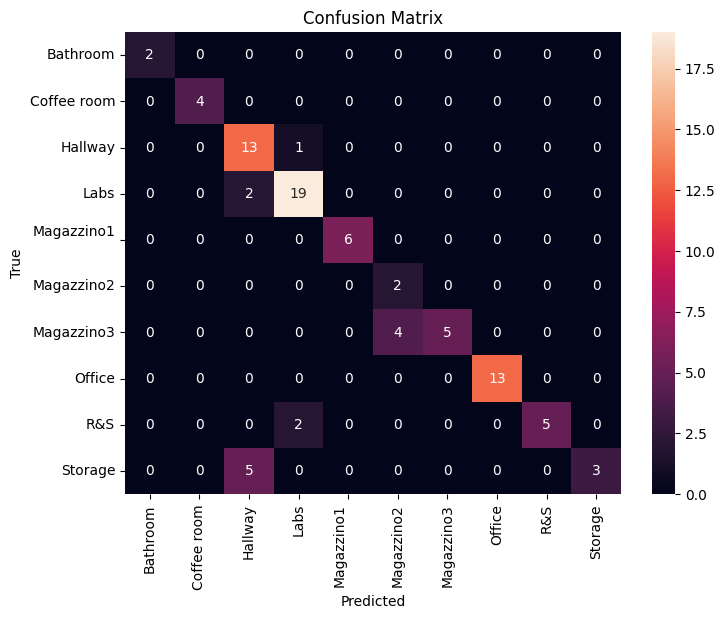


Classification Report:
              precision    recall  f1-score   support

    Bathroom       1.00      1.00      1.00         2
 Coffee room       1.00      1.00      1.00         4
     Hallway       0.65      0.93      0.76        14
        Labs       0.86      0.90      0.88        21
 Magazzino1
       1.00      1.00      1.00         6
  Magazzino2       0.33      1.00      0.50         2
  Magazzino3       1.00      0.56      0.71         9
      Office       1.00      1.00      1.00        13
         R&S       1.00      0.71      0.83         7
     Storage       1.00      0.38      0.55         8

    accuracy                           0.84        86
   macro avg       0.88      0.85      0.82        86
weighted avg       0.89      0.84      0.84        86

Accuratezza media nel rilevamento delle stanze: 0.84

Stanze difficili da prevedere:
True Room   Predicted Room
Storage     Hallway           5
Magazzino3  Magazzino2        4
Labs        Hallway           2
R&S      

In [146]:
from sklearn.model_selection import train_test_split
import joblib

file_path = r"..\backend\ssid_wifi_data_with_rooms.csv"  

# Caricamento e preparazione dati
df = load_data(file_path)
X, y_encoded, le = prepare_data(df)

# Split del dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Addestramento del modello
model = train_model(X_train, y_train)
log_model_training()

# Valutazione
val_accuracy = model.score(X_val, y_val)
test_accuracy = model.score(X_test, y_test)

print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")

# Predizione e analisi
y_pred = model.predict(X_test)
accuracy = evaluate_predictions(y_test, y_pred, le)
print(f"Accuratezza media nel rilevamento delle stanze: {accuracy:.2f}")

analyze_difficult_rooms(y_test, y_pred, le)
